# **Logistic Regression and SVM**

---

Query pada Big Query

SELECT age, workclass, education, education_num, marital_status, occupation, relationship, race, sex, capital_gain, capital_loss, hours_per_week, native_country, income_bracket
 
FROM `bigquery-public-data.ml_datasets.census_adult_income`

WHERE workclass != ' ?' AND hours_per_week < 100
LIMIT 21945

---

Berdasarkan dataset yang didapat akan dibuat model untuk price prediction

## Import Pustaka

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import linear_model
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder as SklearnOneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, roc_auc_score
from sklearn.preprocessing import PolynomialFeatures
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from scipy.stats import ttest_ind
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay

Proses import pustaka yang akan digunakan pada analisis ini

In [2]:
data = pd.read_csv('h8dsft_P1G2_reynaldimarchiano.csv', skipinitialspace=True)
df = data.copy()
df.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,Private,9th,5,Married-civ-spouse,Other-service,Wife,Black,Female,3411,0,34,United-States,<=50K
1,72,Private,9th,5,Married-civ-spouse,Exec-managerial,Wife,Asian-Pac-Islander,Female,0,0,48,United-States,>50K
2,45,Private,9th,5,Married-civ-spouse,Machine-op-inspct,Wife,White,Female,0,0,40,United-States,>50K
3,31,Private,9th,5,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
4,55,Private,9th,5,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,23,United-States,<=50K


Data loading, sebelumnya dilakukan explore pada file csv. Data tersebut terdapat empty space di setiap kolom yang bertipe string, maka ditambahkan skipinitialspace=True untuk menghapus empty space tersebut, untuk mencegah kebingungan saat filtering atau grouping data.

In [3]:
df.tail()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
21940,37,Private,Some-college,10,Divorced,Adm-clerical,Unmarried,White,Female,0,0,39,United-States,<=50K
21941,49,Private,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
21942,30,Private,9th,5,Never-married,Sales,Not-in-family,White,Male,0,0,40,United-States,<=50K
21943,17,Private,9th,5,Never-married,Other-service,Not-in-family,White,Male,0,0,6,United-States,<=50K
21944,24,Private,9th,5,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,1721,40,United-States,<=50K


Tail dari dataset yang berjumlah 21945 row

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21945 entries, 0 to 21944
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             21945 non-null  int64 
 1   workclass       21945 non-null  object
 2   education       21945 non-null  object
 3   education_num   21945 non-null  int64 
 4   marital_status  21945 non-null  object
 5   occupation      21945 non-null  object
 6   relationship    21945 non-null  object
 7   race            21945 non-null  object
 8   sex             21945 non-null  object
 9   capital_gain    21945 non-null  int64 
 10  capital_loss    21945 non-null  int64 
 11  hours_per_week  21945 non-null  int64 
 12  native_country  21945 non-null  object
 13  income_bracket  21945 non-null  object
dtypes: int64(5), object(9)
memory usage: 2.3+ MB


Info diatas berisi tipe data dari semua kolom, dan bisa disimpulkan kalau tidak ada nilai Null pada data.

## EDA

In [5]:
df.describe()


,age,education_num,capital_gain,capital_loss,hours_per_week
count,21945.000000,21945.000000,21945.00000,21945.000000,21945.000000
mean,38.856596,10.096560,1268.74427,94.949054,41.032627
std,12.979954,2.546186,8190.20916,417.441131,12.246148
min,17.000000,1.000000,0.00000,0.000000,1.000000
25%,29.000000,9.000000,0.00000,0.000000,40.000000
50%,38.000000,10.000000,0.00000,0.000000,40.000000
75%,48.000000,12.000000,0.00000,0.000000,45.000000
max,90.000000,16.000000,99999.00000,3900.000000,99.000000


Tahap diatas untuk melihat central tendency dari dataset.

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Capital Loss')

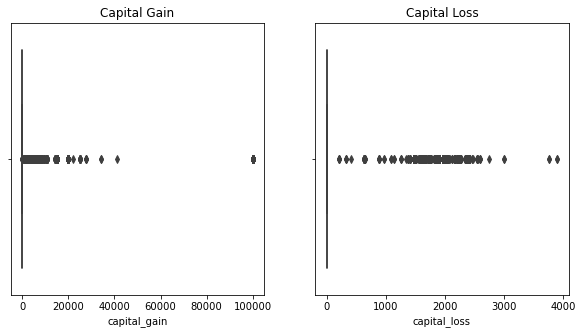

In [6]:
fig = plt.figure(figsize=(10,5))
row = 1
col = 2

# figure, axis = plt.subplots(2,2)
fig.add_subplot(row, col, 1)
sns.boxplot(df['capital_gain'])
plt.title('Capital Gain')

fig.add_subplot(row, col, 2)
sns.boxplot(df['capital_loss'])
plt.title('Capital Loss')

Data capital gain dan loss terlalu jomplang dengan banyak sekali nilai 0, diasumsikan data tersebut belum terisi lengkap maka akan di drop column nantinya

In [7]:
df.groupby(df['occupation'])['hours_per_week'].sum().sort_values(ascending=False)

occupation
Exec-managerial      136928
Craft-repair         133809
Prof-specialty       119799
Sales                108400
Adm-clerical          91947
Other-service         72584
Machine-op-inspct     60287
Transport-moving      55381
Farming-fishing       37289
Handlers-cleaners     36180
Tech-support          24372
Protective-serv       21268
Priv-house-serv        1933
?                       164
Armed-Forces            120
Name: hours_per_week, dtype: int64

Berikut adalah gambaran terhapa jumlah jam kerja untuk setiap pekerjaan.

<AxesSubplot:xlabel='education_num,education'>

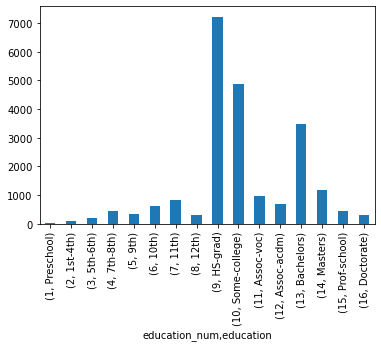

In [8]:
cek1 = df.groupby(df['education_num'])['education'].value_counts().sort_index()
cek1.plot(kind='bar')

Grafik diatas adalah sebaran data untuk kategori education, yg terbanyak adalah 9 HS Grade

In [9]:
df.groupby(df['education_num'])['education'].value_counts().sort_index()

education_num  education   
1              Preschool         22
2              1st-4th           94
3              5th-6th          197
4              7th-8th          433
5              9th              342
6              10th             608
7              11th             817
8              12th             288
9              HS-grad         7223
10             Some-college    4879
11             Assoc-voc        965
12             Assoc-acdm       695
13             Bachelors       3484
14             Masters         1161
15             Prof-school      435
16             Doctorate        302
Name: education, dtype: int64

Dari hasil grouping diatas, bisa dilihat hubungan antara 2 kolom education dan education_num, kolom education merupakan definisi dari education_num, salah satu kolom nantinya akan di drop untuk efisiensi analisis.

In [10]:
plot1=df.groupby(df['education_num'])['income_bracket'].value_counts().reset_index(name='count')
plot2=df.groupby(df['sex'])['income_bracket'].value_counts().reset_index(name='count')
plot2.head()

,sex,income_bracket,count
0,Female,<=50K,5094
1,Female,>50K,838
2,Male,<=50K,10075
3,Male,>50K,5938


<AxesSubplot:xlabel='sex', ylabel='count'>

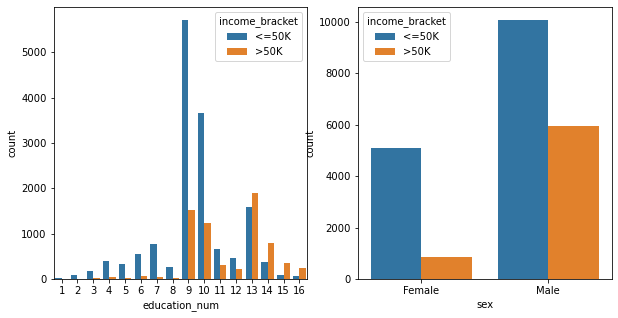

In [11]:
fig = plt.figure(figsize=(10,5))
row = 1
col = 2

# figure, axis = plt.subplots(2,2)
fig.add_subplot(row, col, 1)
sns.barplot(data=plot1,x='education_num',y='count',hue='income_bracket')

fig.add_subplot(row, col, 2)
sns.barplot(data=plot2,x='sex',y='count',hue='income_bracket')


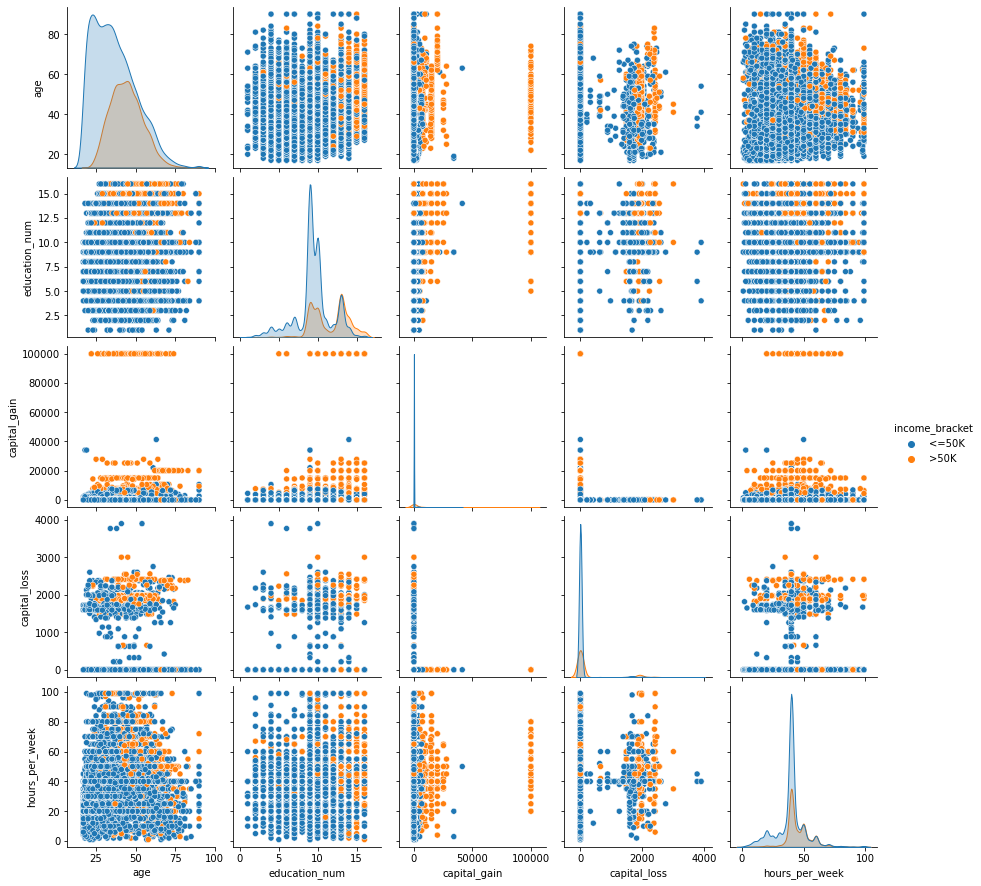

In [12]:
sns.pairplot(df,hue='income_bracket')

Macam-macam plotting diatas adalah untuk melihat hubungan plot satu antara yang lain dari setiap kolom. Bisa dilihat data tersebut banyak overlap dan hampir tidak berkorelasi.

<AxesSubplot:>

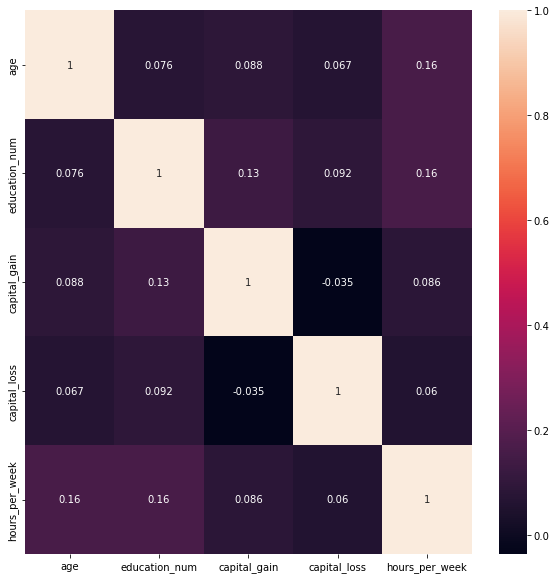

In [13]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),annot=True)

Berikut adalah heatmap untuk melihat korelasi antar kolom. Lanjutan dari grafik sebelumnya, kolom numerik pada data ini cenderung tidak berkorelasi sesuai dengan nilai korelasi yang dihasilkan yang mana jauh dari angka 1.

## Data Preprocessing

In [14]:
df.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,Private,9th,5,Married-civ-spouse,Other-service,Wife,Black,Female,3411,0,34,United-States,<=50K
1,72,Private,9th,5,Married-civ-spouse,Exec-managerial,Wife,Asian-Pac-Islander,Female,0,0,48,United-States,>50K
2,45,Private,9th,5,Married-civ-spouse,Machine-op-inspct,Wife,White,Female,0,0,40,United-States,>50K
3,31,Private,9th,5,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
4,55,Private,9th,5,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,23,United-States,<=50K


Menampilkan data awal sebelumnya dilakukan drop column, filtering, dan grouping.

In [15]:
df.drop(columns=['capital_gain','capital_loss','education'],inplace=True)

Ada 3 kolom yang didrop sesuai analisa dari EDA.

In [16]:
df.head()

,age,workclass,education_num,marital_status,occupation,relationship,race,sex,hours_per_week,native_country,income_bracket
0,39,Private,5,Married-civ-spouse,Other-service,Wife,Black,Female,34,United-States,<=50K
1,72,Private,5,Married-civ-spouse,Exec-managerial,Wife,Asian-Pac-Islander,Female,48,United-States,>50K
2,45,Private,5,Married-civ-spouse,Machine-op-inspct,Wife,White,Female,40,United-States,>50K
3,31,Private,5,Married-civ-spouse,Exec-managerial,Wife,White,Female,40,United-States,<=50K
4,55,Private,5,Married-civ-spouse,Tech-support,Wife,White,Female,23,United-States,<=50K


Tampilan data setelah ada 3 kolom yang di drop.

## Inference

In [17]:
# get data for model inference
df_inf = df.sample(10, random_state=95)
df_inf

,age,workclass,education_num,marital_status,occupation,relationship,race,sex,hours_per_week,native_country,income_bracket
4668,57,Self-emp-not-inc,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,45,United-States,<=50K
3829,44,Self-emp-not-inc,9,Married-civ-spouse,Prof-specialty,Husband,White,Male,40,United-States,>50K
13538,42,Self-emp-not-inc,10,Married-civ-spouse,Craft-repair,Husband,White,Male,45,United-States,<=50K
17468,26,Federal-gov,10,Never-married,Tech-support,Own-child,White,Female,40,United-States,<=50K
14356,17,Private,6,Never-married,Other-service,Own-child,White,Male,15,United-States,<=50K
14838,23,Private,8,Married-civ-spouse,Handlers-cleaners,Own-child,White,Male,40,United-States,<=50K
84,45,Private,2,Married-civ-spouse,Other-service,Wife,White,Female,25,El-Salvador,<=50K
20640,24,Self-emp-not-inc,11,Never-married,Other-service,Unmarried,White,Female,38,United-States,<=50K
4735,45,Self-emp-inc,9,Married-civ-spouse,Craft-repair,Husband,White,Male,50,United-States,>50K
16887,25,Private,13,Never-married,Prof-specialty,Own-child,Asian-Pac-Islander,Male,40,Taiwan,<=50K


Mengambil 10 data inference untuk nantinya diuji coba terhadap model yang sudah dibuat.

In [18]:
df_train_test = df.drop(df_inf.index)
df_train_test

,age,workclass,education_num,marital_status,occupation,relationship,race,sex,hours_per_week,native_country,income_bracket
0,39,Private,5,Married-civ-spouse,Other-service,Wife,Black,Female,34,United-States,<=50K
1,72,Private,5,Married-civ-spouse,Exec-managerial,Wife,Asian-Pac-Islander,Female,48,United-States,>50K
2,45,Private,5,Married-civ-spouse,Machine-op-inspct,Wife,White,Female,40,United-States,>50K
3,31,Private,5,Married-civ-spouse,Exec-managerial,Wife,White,Female,40,United-States,<=50K
4,55,Private,5,Married-civ-spouse,Tech-support,Wife,White,Female,23,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...
21940,37,Private,10,Divorced,Adm-clerical,Unmarried,White,Female,39,United-States,<=50K
21941,49,Private,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,16,Jamaica,<=50K
21942,30,Private,5,Never-married,Sales,Not-in-family,White,Male,40,United-States,<=50K
21943,17,Private,5,Never-married,Other-service,Not-in-family,White,Male,6,United-States,<=50K


Data yang telah dipisahkan dari 10 data inference disimpan dalam variabel df_train_test

In [19]:
# reset index
df_train_test.reset_index(drop=True, inplace=True)
df_inf.reset_index(drop=True, inplace=True)
df_inf

,age,workclass,education_num,marital_status,occupation,relationship,race,sex,hours_per_week,native_country,income_bracket
0,57,Self-emp-not-inc,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,45,United-States,<=50K
1,44,Self-emp-not-inc,9,Married-civ-spouse,Prof-specialty,Husband,White,Male,40,United-States,>50K
2,42,Self-emp-not-inc,10,Married-civ-spouse,Craft-repair,Husband,White,Male,45,United-States,<=50K
3,26,Federal-gov,10,Never-married,Tech-support,Own-child,White,Female,40,United-States,<=50K
4,17,Private,6,Never-married,Other-service,Own-child,White,Male,15,United-States,<=50K
5,23,Private,8,Married-civ-spouse,Handlers-cleaners,Own-child,White,Male,40,United-States,<=50K
6,45,Private,2,Married-civ-spouse,Other-service,Wife,White,Female,25,El-Salvador,<=50K
7,24,Self-emp-not-inc,11,Never-married,Other-service,Unmarried,White,Female,38,United-States,<=50K
8,45,Self-emp-inc,9,Married-civ-spouse,Craft-repair,Husband,White,Male,50,United-States,>50K
9,25,Private,13,Never-married,Prof-specialty,Own-child,Asian-Pac-Islander,Male,40,Taiwan,<=50K


Reset index dari kedua dataframe yang telah dipisahkan.

## Splitting Dataset

In [20]:
# Split between `X` (Features) and `y` (Target)
X = df_train_test.drop('income_bracket',axis=1)
y = df_train_test['income_bracket']
X

,age,workclass,education_num,marital_status,occupation,relationship,race,sex,hours_per_week,native_country
0,39,Private,5,Married-civ-spouse,Other-service,Wife,Black,Female,34,United-States
1,72,Private,5,Married-civ-spouse,Exec-managerial,Wife,Asian-Pac-Islander,Female,48,United-States
2,45,Private,5,Married-civ-spouse,Machine-op-inspct,Wife,White,Female,40,United-States
3,31,Private,5,Married-civ-spouse,Exec-managerial,Wife,White,Female,40,United-States
4,55,Private,5,Married-civ-spouse,Tech-support,Wife,White,Female,23,United-States
...,...,...,...,...,...,...,...,...,...,...
21930,37,Private,10,Divorced,Adm-clerical,Unmarried,White,Female,39,United-States
21931,49,Private,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,16,Jamaica
21932,30,Private,5,Never-married,Sales,Not-in-family,White,Male,40,United-States
21933,17,Private,5,Never-married,Other-service,Not-in-family,White,Male,6,United-States


Sekarang memisahkan data fitur dan data target ke dalam variabel X dan y

In [21]:
# Split between Train-Set and Test-Set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

# # split data into train+validation set and test set
# X_trainval, X_test, y_trainval, y_test = train_test_split(X,y, random_state=22)
# # split train+validation set into training and validation sets
# X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, random_state=28)
print('X_train Size =', X_train.shape)
print('X_test Size  =', X_test.shape)
print('y_train Size =', y_train.shape)
print('y_test Size  =', y_test.shape)

X_train Size = (17548, 10)
X_test Size  = (4387, 10)
y_train Size = (17548,)
y_test Size  = (4387,)


Setelah itu dibuat juga ke dalam train-test set untuk kedua variabel.

## Handling Missing Value

In [22]:
X_train.isnull().sum()

age               0
workclass         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
hours_per_week    0
native_country    0
dtype: int64

Tidak ada missing value di X_train

In [23]:
y_train.isnull().sum()

0

Tidak ada missing value di y_train

In [24]:
X_test.isnull().sum()

age               0
workclass         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
hours_per_week    0
native_country    0
dtype: int64

Tidak ada missing value di X_test

In [25]:
y_test.isnull().sum()

0

Tidak ada missing value di y_test

Tidak ada missing value pada train test set

## Handling Outlier

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'HPW')

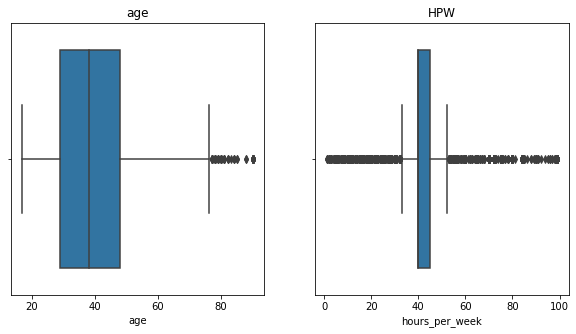

In [26]:
fig = plt.figure(figsize=(10,5))
row = 1
col = 2

# figure, axis = plt.subplots(2,2)
fig.add_subplot(row, col, 1)
sns.boxplot(X_train['age'])
plt.title('age')

fig.add_subplot(row, col, 2)
sns.boxplot(X_train['hours_per_week'])
plt.title('HPW')

Dari hasil boxplot diatas, dapat dilihat bahwa ada outliers pada kolom age dan hours per week

In [27]:
print('X_train skewness =\n',X_train.skew())
print('X_test skewness =\n',X_test.skew())

X_train skewness =
 age               0.417742
education_num    -0.236332
hours_per_week    0.339140
dtype: float64
X_test skewness =
 age               0.426462
education_num    -0.227827
hours_per_week    0.253405
dtype: float64


C:\Users\DELL\AppData\Local\Temp/ipykernel_15328/3996075523.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print('X_train skewness =\n',X_train.skew())
C:\Users\DELL\AppData\Local\Temp/ipykernel_15328/3996075523.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print('X_test skewness =\n',X_test.skew())


dari X train test set didapatkan bahwa sebaran datanya right skewed karena skewness bernilai <0.5

In [28]:
print('Umur Minimum =',X_train['age'].min())
print('Umur Maximum =',X_train['age'].max())
print('Hours Per Week Minimum =',X_train['hours_per_week'].min())
print('Hours Per Week Maximum =',X_train['hours_per_week'].max())

Umur Minimum = 17
Umur Maximum = 90
Hours Per Week Minimum = 1
Hours Per Week Maximum = 99


Jika dilihat nilai min dan max dari kedua kolom tersebut, minimum pada age tergolong masuk akal. Lain hal untuk minimum dan maximum di hours yang perlu di handling outliers. Maximum age juga perlu disesuaikan dengan sebaran data.

In [29]:
q1age,q2age,q3age = X_train['age'].quantile([0.25, 0.5, 0.75])
q1hpw,q2hpw,q3hpw = X_train['hours_per_week'].quantile([0.25, 0.5, 0.75])

print(X_train['age'].quantile([0.25, 0.5, 0.75]))
print(X_train['hours_per_week'].quantile([0.25, 0.5, 0.75]))

0.25    29.0
0.50    38.0
0.75    48.0
Name: age, dtype: float64
0.25    40.0
0.50    40.0
0.75    45.0
Name: hours_per_week, dtype: float64


Mendapatkan nilai q1,q2,q3

In [30]:
iqrage = q3age-q1age
iqrhpw = q3hpw - q1hpw

minage = q1age - (1.5*iqrage)
maxage = q3age + (1.5*iqrage)
minhpw = q1hpw - (1.5*iqrhpw)
maxhpw = q3hpw + (1.5*iqrhpw)

print("Batas Minimum Outlier X_train Age =", minage)
print("Batas Maximum Outlier X_train Age =", maxage)
print("Batas Minimum Outlier X_train Hours Per Week =", minhpw)
print("Batas Maximum Outlier X_train Hours Per Week =", maxhpw)

Batas Minimum Outlier X_train Age = 0.5
Batas Maximum Outlier X_train Age = 76.5
Batas Minimum Outlier X_train Hours Per Week = 32.5
Batas Maximum Outlier X_train Hours Per Week = 52.5


Perhitungan batas minimum dan maximum outlier

In [31]:
ix = (X_train[(X_train['age']>maxage) | (X_train['hours_per_week']<minhpw) | (X_train['hours_per_week']>maxhpw)]).index
ix

Int64Index([14661, 18456,  8445,  8021, 15199, 17539, 12164, 18242,  3298,
            16088,
            ...
            14314,  6679,  7801,  6683, 15016,  2985, 14808,  5646, 13970,
            21862],
           dtype='int64', length=4746)

Query data untuk membuang outlier dengan menyimpan list indexnya

In [32]:
X_train.drop(ix,inplace=True)

Filtering data X_train sesuai index hasil query

In [33]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12802 entries, 15854 to 11125
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             12802 non-null  int64 
 1   workclass       12802 non-null  object
 2   education_num   12802 non-null  int64 
 3   marital_status  12802 non-null  object
 4   occupation      12802 non-null  object
 5   relationship    12802 non-null  object
 6   race            12802 non-null  object
 7   sex             12802 non-null  object
 8   hours_per_week  12802 non-null  int64 
 9   native_country  12802 non-null  object
dtypes: int64(3), object(7)
memory usage: 1.1+ MB


Data X_train sudah berkurang hasil handling outlier

In [34]:
X_train.reset_index()

,index,age,workclass,education_num,marital_status,occupation,relationship,race,sex,hours_per_week,native_country
0,15854,38,Federal-gov,9,Never-married,Adm-clerical,Own-child,Black,Female,40,United-States
1,17505,20,Private,10,Never-married,Sales,Own-child,White,Male,40,United-States
2,9291,49,Private,13,Married-civ-spouse,Other-service,Husband,White,Male,40,United-States
3,10252,43,Private,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,40,United-States
4,14128,53,Private,10,Married-civ-spouse,Transport-moving,Husband,White,Male,45,United-States
...,...,...,...,...,...,...,...,...,...,...,...
12797,9181,29,Private,13,Married-civ-spouse,Tech-support,Husband,White,Male,40,United-States
12798,18911,45,Private,7,Married-spouse-absent,Machine-op-inspct,Unmarried,Asian-Pac-Islander,Female,40,South
12799,15956,21,Private,9,Never-married,Sales,Own-child,White,Female,36,United-States
12800,20971,64,Private,13,Divorced,Exec-managerial,Unmarried,White,Male,50,United-States


mereset index dari X_train

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'HPW')

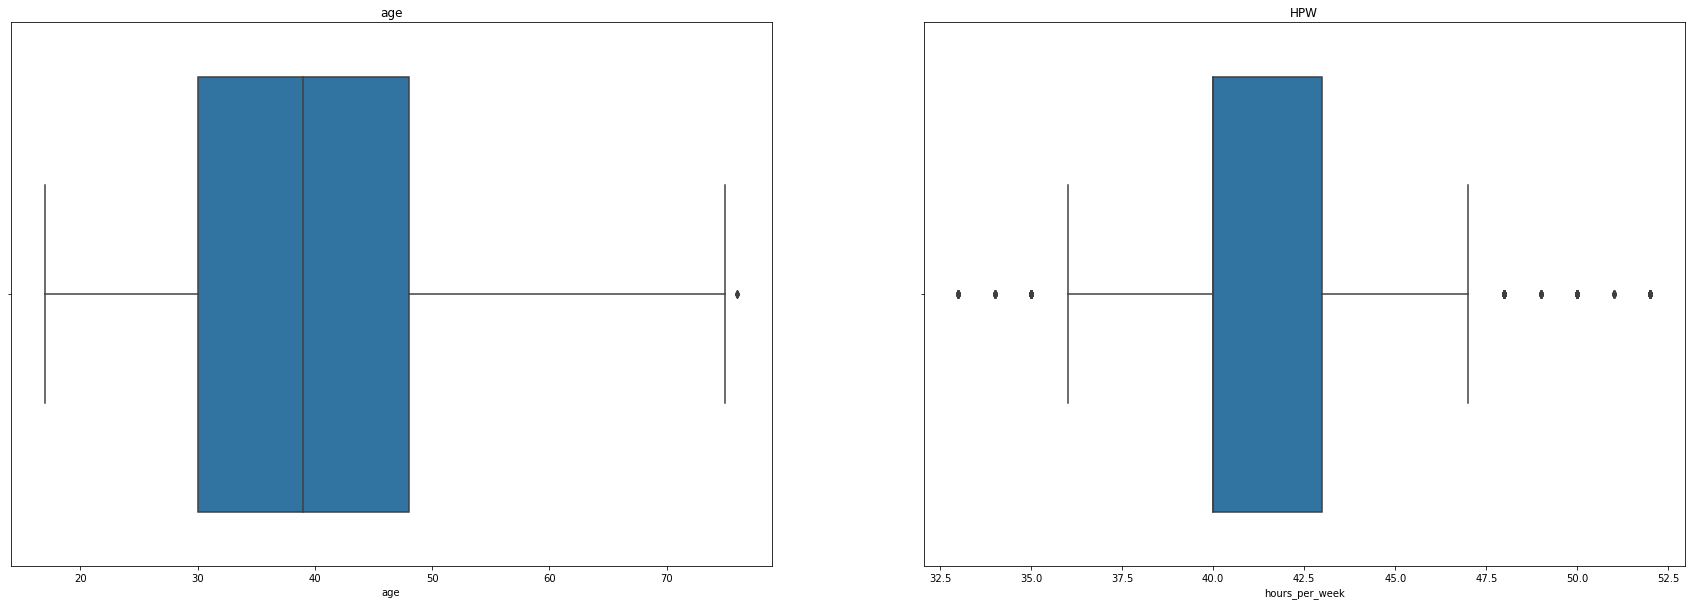

In [35]:
fig = plt.figure(figsize=(30,10))
row = 1
col = 2

# figure, axis = plt.subplots(2,2)
fig.add_subplot(row, col, 1)
sns.boxplot(X_train['age'])
plt.title('age')

fig.add_subplot(row, col, 2)
sns.boxplot(X_train['hours_per_week'])
plt.title('HPW')

Hasil boxplot diatas terlihat lebih baik dengan berkurangnya outlier yang telah di handle

In [36]:
y_train.drop(ix,inplace=True)

menyesuaikan row data sesua dengan X_train berdasarkan index row yg di drop tadi

In [37]:
y_train.reset_index()

,index,income_bracket
0,15854,<=50K
1,17505,<=50K
2,9291,<=50K
3,10252,<=50K
4,14128,>50K
...,...,...
12797,9181,<=50K
12798,18911,<=50K
12799,15956,<=50K
12800,20971,>50K


reset_index dari y_train

In [38]:
print('X_train Size =', X_train.shape)
print('X_test Size  =', X_test.shape)
print('y_train Size =', y_train.shape)
print('y_test Size  =', y_test.shape)

X_train Size = (12802, 10)
X_test Size  = (4387, 10)
y_train Size = (12802,)
y_test Size  = (4387,)


Berikut adalah ukuran dari 4 variabel X y train set setelah handling outlier

In [39]:
# print(;asf)

## Feature Selection

In [40]:
# Get Numerical Columns and Categorical Columns

num_columns = X_train.select_dtypes(include=np.number).columns.tolist()
cat_columns = X_train.select_dtypes(include=['object']).columns.tolist()

print('Numerical Columns : ', num_columns)
print('Categorical Columns : ', cat_columns)

Numerical Columns :  ['age', 'education_num', 'hours_per_week']
Categorical Columns :  ['workclass', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']


Pemisahan antara kolom numerikal dan kategorikal

In [41]:
# Split Train-Set and Test-Set based on Column Types

X_train_num = X_train[num_columns]
X_train_cat = X_train[cat_columns]

X_test_num = X_test[num_columns]
X_test_cat = X_test[cat_columns]

Untuk train set juga dipisahkan berdasarkan numerikal dan kategorikal

In [42]:
X_test_cat

,workclass,marital_status,occupation,relationship,race,sex,native_country
18771,Private,Separated,Adm-clerical,Unmarried,White,Male,United-States
13776,Self-emp-not-inc,Married-civ-spouse,Exec-managerial,Husband,Amer-Indian-Eskimo,Male,United-States
10904,Self-emp-inc,Married-civ-spouse,Exec-managerial,Husband,Asian-Pac-Islander,Male,Taiwan
5598,Private,Married-civ-spouse,Sales,Husband,White,Male,United-States
15096,Private,Never-married,Other-service,Own-child,White,Male,United-States
...,...,...,...,...,...,...,...
12660,Private,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States
3224,Private,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,United-States
1447,Private,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,Mexico
4492,Private,Married-civ-spouse,Other-service,Husband,Black,Male,United-States


Data diatas adalah salah satu contoh ketika dipisahkan data kategorikal dari X_test menjadi X_test_cat

## Feature Scaling

In [43]:
X_train_num.head()

,age,education_num,hours_per_week
15854,38,9,40
17505,20,10,40
9291,49,13,40
10252,43,13,40
14128,53,10,45


Tampilan 5 data awal X_train_num

In [44]:
X_train_num.skew()

age               0.300483
education_num    -0.283803
hours_per_week    1.024320
dtype: float64

Data X_train_num sedikit skewed karena != 0 , maka perlu discaling menggunakan MinMaxScaler

In [45]:
# Feature Scaling using MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train_num)

X_train_num_scaled = scaler.transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

X_train_num_scaled

array([[0.3559322 , 0.53333333, 0.36842105],
       [0.05084746, 0.6       , 0.36842105],
       [0.54237288, 0.8       , 0.36842105],
       ...,
       [0.06779661, 0.53333333, 0.15789474],
       [0.79661017, 0.8       , 0.89473684],
       [0.38983051, 0.73333333, 0.36842105]])

Proses scaling dengan fit transfrom untuk X_train_num, dan transform saja untuk X_test_num

In [46]:
print(X_train_num_scaled.shape)
print(X_test_num_scaled.shape)

(12802, 3)
(4387, 3)


Ukuran X_train_num dan X_test_num setelah di scaling

## Feature Encoding

In [47]:
X_train_cat.head()

,workclass,marital_status,occupation,relationship,race,sex,native_country
15854,Federal-gov,Never-married,Adm-clerical,Own-child,Black,Female,United-States
17505,Private,Never-married,Sales,Own-child,White,Male,United-States
9291,Private,Married-civ-spouse,Other-service,Husband,White,Male,United-States
10252,Private,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States
14128,Private,Married-civ-spouse,Transport-moving,Husband,White,Male,United-States


Tampilan data awal yang kategorikal di X_train

In [48]:
# y_train_df = pd.DataFrame(y_train)
# y_test_df = pd.DataFrame(y_test)
# y_train_df

In [49]:
class OneHotEncoder(SklearnOneHotEncoder):
    def __init__(self, **kwargs):
        super(OneHotEncoder, self).__init__(**kwargs)
        self.fit_flag = False

    def fit(self, X, **kwargs):
        out = super().fit(X)
        self.fit_flag = True
        return out

    def transform(self, X, **kwargs):
        sparse_matrix = super(OneHotEncoder, self).transform(X)
        new_columns = self.get_new_columns(X=X)
        d_out = pd.DataFrame(sparse_matrix.toarray(), columns=new_columns, index=X.index)
        return d_out

    def fit_transform(self, X, **kwargs):
        self.fit(X)
        return self.transform(X)

    def get_new_columns(self, X):
        new_columns = []
        for i, column in enumerate(X.columns):
            j = 0
            while j < len(self.categories_[i]):
                new_columns.append(f'{column}_<{self.categories_[i][j]}>')
                j += 1
        return new_columns

Coding untuk menyesuaikan OneHotEncoder agar bisa langsung memunculkan nama kolom di outputnya.

In [50]:
# Feature Encoding using OrdinalEcoder

encoder = OneHotEncoder()
X_train_cat_encoded = encoder.fit_transform(X_train_cat)
X_train_cat_encoded.shape

(12802, 83)

Menggunakan OneHotEncoder karena data kategorikal bersifal nominal atau tidak memiliki tingkatan.

In [51]:
X_train_cat_encoded

,workclass_<Federal-gov>,workclass_<Local-gov>,workclass_<Never-worked>,workclass_<Private>,workclass_<Self-emp-inc>,workclass_<Self-emp-not-inc>,workclass_<State-gov>,workclass_<Without-pay>,marital_status_<Divorced>,marital_status_<Married-AF-spouse>,...,native_country_<Portugal>,native_country_<Puerto-Rico>,native_country_<Scotland>,native_country_<South>,native_country_<Taiwan>,native_country_<Thailand>,native_country_<Trinadad&Tobago>,native_country_<United-States>,native_country_<Vietnam>,native_country_<Yugoslavia>
15854,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
17505,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9291,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
10252,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
14128,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9181,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
18911,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
15956,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
20971,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Hasil encoding dari X_train_cat bisa dilihat di atas.

In [52]:
X_test_cat_encoded = encoder.transform(X_test_cat)
X_test_cat_encoded

,workclass_<Federal-gov>,workclass_<Local-gov>,workclass_<Never-worked>,workclass_<Private>,workclass_<Self-emp-inc>,workclass_<Self-emp-not-inc>,workclass_<State-gov>,workclass_<Without-pay>,marital_status_<Divorced>,marital_status_<Married-AF-spouse>,...,native_country_<Portugal>,native_country_<Puerto-Rico>,native_country_<Scotland>,native_country_<South>,native_country_<Taiwan>,native_country_<Thailand>,native_country_<Trinadad&Tobago>,native_country_<United-States>,native_country_<Vietnam>,native_country_<Yugoslavia>
18771,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
13776,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
10904,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5598,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
15096,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12660,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3224,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1447,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4492,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [53]:
le = LabelEncoder()

Fungsi labelencoder untuk data target karena bersifat kategorikal nominal.

In [54]:
y_train_encoded = le.fit_transform(y_train)
y_train_encoded

array([0, 0, 0, ..., 0, 1, 1])

Untuk y_train juga di encoding karena bersifat kategorikal nominal.

In [55]:
y_test_encoded = le.transform(y_test)
y_test_encoded

array([0, 0, 1, ..., 0, 0, 0])

Untuk y_train juga di encoding karena bersifat kategorikal nominal.

In [59]:
# Concate Columns
X_train_final = np.concatenate([X_train_num_scaled, X_train_cat_encoded], axis=1)
X_test_final = np.concatenate([X_test_num_scaled, X_test_cat_encoded], axis=1)

X_train_final

array([[0.3559322 , 0.53333333, 0.36842105, ..., 1.        , 0.        ,
        0.        ],
       [0.05084746, 0.6       , 0.36842105, ..., 1.        , 0.        ,
        0.        ],
       [0.54237288, 0.8       , 0.36842105, ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.06779661, 0.53333333, 0.15789474, ..., 1.        , 0.        ,
        0.        ],
       [0.79661017, 0.8       , 0.89473684, ..., 1.        , 0.        ,
        0.        ],
       [0.38983051, 0.73333333, 0.36842105, ..., 1.        , 0.        ,
        0.        ]])

Penggabungan data final dari data yang telah di scaling dan encoding

In [60]:
print('X_train Size =', X_train_final.shape)
print('X_test Size  =', X_test_final.shape)
print('y_train Size =', y_train_encoded.shape)
print('y_test Size  =', y_test_encoded.shape)

X_train Size = (12802, 86)
X_test Size  = (4387, 86)
y_train Size = (12802,)
y_test Size  = (4387,)


Ukuran dari data X y Train test final

## Model Definition

### Logistic Regression

In [61]:
model_log_reg = LogisticRegression()

Pengdefinisial model logistik regresi

In [64]:
model_log_reg.fit(X_train_final, y_train_encoded)

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Melakukan fit logisticregression untuk X_train_final dan y_train_encoded

In [67]:
#Predict testing set
y_pred = model_log_reg.predict(X_test_final)
y_pred

array([0, 1, 1, ..., 0, 0, 0])

Prediksi berdasarkan model regresi logistik

In [68]:
print(classification_report(y_test_encoded, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.86      0.85      3072
           1       0.66      0.65      0.66      1315

    accuracy                           0.80      4387
   macro avg       0.76      0.75      0.76      4387
weighted avg       0.79      0.80      0.79      4387



Hasil classification report bisa terlihat untuk accuract sebesar 80%

In [74]:
roc_auc_score(y_test_encoded, y_pred)

0.7535338195104563

Score ROC AUC Score tidak terlalu bagus, dianggap cukup saja

### Hyperparameter Tuning

In [75]:
#define parameters
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l1', 'l2']
cval    = [1, 10, 100]

#define grid
grid = dict(solver=solvers,penalty=penalty,C=cval)

Mencoba mencari hyperparameter terbaik dengan beberapa parameter yang akan dicoba sesuai cell diatas.

In [77]:
grid_search = GridSearchCV(estimator=model_log_reg, param_grid=grid, n_jobs=-1, cv=3, scoring='accuracy',error_score=0,return_train_score=True)

Pencarian hyperparameter terbaik menggunakan GridSearchCV

In [79]:
best_model = grid_search.fit(X_train_final, y_train_encoded)

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
18 fits failed out of a total of 54.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueEr

Melakukan fit kembali dengan hyperparameter terbaik dari yang telah dicari sebelumnya dengan GridSearchCV

----

### Logistic Regression Evaluation

----

In [80]:
#Nilai hyperpaameters terbaik
print("Test set score: {:.2f}".format(grid_search.score(X_test_final, y_test_encoded)))
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Best estimator:\n{}".format(grid_search.best_estimator_))

Test set score: 0.80
Best parameters: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best cross-validation score: 0.79
Best estimator:
LogisticRegression(C=1)


'C': 1, 'penalty': 'l2', 'solver': 'lbfgs' ini merupakan hyperparameter terbaik hasil dari GridSearchCV

In [81]:
y_pred2 = best_model.predict(X_test_final)

Mencoba prediksi kedua di model regresi logistik dengan hyperparameter terbaik

In [82]:
print(classification_report(y_test_encoded, y_pred2))

              precision    recall  f1-score   support

           0       0.85      0.86      0.85      3072
           1       0.66      0.65      0.66      1315

    accuracy                           0.80      4387
   macro avg       0.76      0.75      0.76      4387
weighted avg       0.79      0.80      0.79      4387



Berdasarkan classification report nampak tidak ada perubahan dari score accuracy

In [83]:
y_pred2= best_model.predict(X_test_final)
roc_auc_score(y_test_encoded, y_pred2)

0.7535338195104563

Nilai dari ROC AUC nya pun sama dengan sebelumnya.
Diasumsikan model perubahan hyperparameter tidak memberikan perbedaan dalam akurasi.

----

### SVM

---

In [85]:
svm = SVC(kernel='rbf',gamma=1,C=1)
svm.fit(X_train_final, y_train_encoded)

SVC(C=1, gamma=1)

Pendefinisian model SVM dengan menggunakan hyperparameter kernel rbf, gamma = 1, dan C=1

In [86]:
y_predsvm = svm.predict(X_test_final)

Melakukan prediksi dengan model svm

In [87]:
print(classification_report(y_test_encoded, y_predsvm))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85      3072
           1       0.67      0.56      0.61      1315

    accuracy                           0.79      4387
   macro avg       0.75      0.72      0.73      4387
weighted avg       0.78      0.79      0.78      4387



Berdasarkan classification report akurasi model tersebut sebar 79%.

## Model Evaluation

In [91]:
# Predict Train-Set and Test-Set
y_logpred_train = best_model.predict(X_train_final)
y_logpred_test = best_model.predict(X_test_final)

y_svmpred_train = svm.predict(X_train_final)
y_svmpred_test = svm.predict(X_test_final)


Untuk rangkuman, mencoba melakukan prediksi ulang dengan 2 model yang telah dibuat.

In [129]:
print('Log Reg Accuracy Score Train :', accuracy_score(y_train_encoded,y_logpred_train))
print('log Reg Accuracy Score Test :', accuracy_score(y_test_encoded,y_logpred_test))
print('')
print('SVM Accuracy Score Train :', accuracy_score(y_train_encoded,y_svmpred_train))
print('SVM Accuracy Score Test :', accuracy_score(y_test_encoded,y_svmpred_test))

Log Reg Accuracy Score Train : 0.7970629589126699
log Reg Accuracy Score Test : 0.7955322543879645

SVM Accuracy Score Train : 0.813857209810967
SVM Accuracy Score Test : 0.7861864599954411


Berikut adalah score dari masing-masing model train dan test.

Untuk Regresi Logistik dengan nilai skor yang cukup konsisten bisa diasumsikan model tersebut good fit dalam melakukan prediksi.

Untuk SVM nilai skor test lebih rendah sekitar 3% dari Train, bisa diasumsikan modelnya overfitting dalam melakukan prediksi

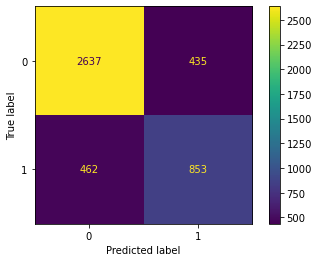

In [104]:
cm = confusion_matrix(y_test_encoded,y_logpred_test, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=best_model.classes_)

disp.plot()
plt.show()

## Model Saving

In [105]:
# Model Saving

import pickle

with open('model_scaler.pkl', 'wb') as file_1:
  pickle.dump(scaler, file_1)

with open('model_encoder.pkl', 'wb') as file_2:
  pickle.dump(encoder, file_2)

with open('model_log_reg.pkl', 'wb') as file_3:
  pickle.dump(best_model, file_3)

with open('model_svm.pkl', 'wb') as file_6:
  pickle.dump(svm, file_6)

with open('list_num_columns.txt', 'w') as file_4:
  file_4.write(str(num_columns))

with open('list_cat_columns.txt', 'w') as file_5:
  file_5.write(str(cat_columns))

Penyimpanan model-model yang telah dibuat ke dalam pickle

Menyimpan model yang telah dibuat

## Model Inference

### Load Model

In [114]:
# Load All Files

with open('model_scaler.pkl', 'rb') as file_1:
  model_scaler = pickle.load(file_1)

with open('model_encoder.pkl', 'rb') as file_2:
  model_encoder = pickle.load(file_2)

with open('model_log_reg.pkl', 'rb') as file_3:
  model_log_reg = pickle.load(file_3)

with open('list_num_columns.txt', 'r') as file_4:
  list_num_columns = file_4.read()

with open('list_cat_columns.txt', 'r') as file_5:
  list_cat_columns = file_5.read()

with open('model_svm.pkl', 'rb') as file_6:
  model_svm = pickle.load(file_6)

Load model yang telah dibuat.

In [107]:
# Convert `num_columns` and `cat_columns` into List

import ast

list_num_columns = ast.literal_eval(list_num_columns)
list_cat_columns = ast.literal_eval(list_cat_columns)
list_num_columns

['age', 'education_num', 'hours_per_week']

### Inferencing

In [108]:
# Split between Numerical Columns and Categorical Columns

df_inf_num = df_inf[list_num_columns]
df_inf_cat = df_inf[list_cat_columns]

df_inf_num

,age,education_num,hours_per_week
0,57,9,45
1,44,9,40
2,42,10,45
3,26,10,40
4,17,6,15
5,23,8,40
6,45,2,25
7,24,11,38
8,45,9,50
9,25,13,40


Split data numerik dan kategorik pada data yang akan diprediksi

In [109]:
# Feature Scaling and Feature Encoding

df_inf_num_scaled = model_scaler.transform(df_inf_num)
df_inf_cat_encoded = model_encoder.transform(df_inf_cat)
df_inf_num_scaled

array([[ 0.6779661 ,  0.53333333,  0.63157895],
       [ 0.45762712,  0.53333333,  0.36842105],
       [ 0.42372881,  0.6       ,  0.63157895],
       [ 0.15254237,  0.6       ,  0.36842105],
       [ 0.        ,  0.33333333, -0.94736842],
       [ 0.10169492,  0.46666667,  0.36842105],
       [ 0.47457627,  0.06666667, -0.42105263],
       [ 0.11864407,  0.66666667,  0.26315789],
       [ 0.47457627,  0.53333333,  0.89473684],
       [ 0.13559322,  0.8       ,  0.36842105]])

Dilakukan scaling pada data numerik dan encoding untuk data kategorik.

In [110]:
# Concate Numerical Columns and Categorical Columns

df_inf_final = np.concatenate([df_inf_num_scaled, df_inf_cat_encoded], axis=1)
df_inf_final

array([[ 0.6779661 ,  0.53333333,  0.63157895,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

Digabungkan kembali menjadi 1 matriks.

In [115]:
# Predict Inference-Set

y_pred_inf = model_log_reg.predict(df_inf_final)
y_pred_inf

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

Menggunakan model logistic regression, dilakukan income_bracket prediction dari df_inf tadi.

In [122]:
# Convert into DataFrame

y_pred_inf_df = pd.DataFrame(y_pred_inf, columns=['Income_Bracket Prediction'])
y_pred_inf_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 1 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Income_Bracket Prediction  10 non-null     int32
dtypes: int32(1)
memory usage: 168.0 bytes


Berikut hasil prediksi berdasarkan model yang telah dibuat.

In [119]:
# Merge Inference-Set and Prediction

pd.concat([df_inf, y_pred_inf_df], axis=1)

,age,workclass,education_num,marital_status,occupation,relationship,race,sex,hours_per_week,native_country,income_bracket,Income_Bracket Prediction
0,57,Self-emp-not-inc,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,45,United-States,<=50K,0
1,44,Self-emp-not-inc,9,Married-civ-spouse,Prof-specialty,Husband,White,Male,40,United-States,>50K,0
2,42,Self-emp-not-inc,10,Married-civ-spouse,Craft-repair,Husband,White,Male,45,United-States,<=50K,0
3,26,Federal-gov,10,Never-married,Tech-support,Own-child,White,Female,40,United-States,<=50K,0
4,17,Private,6,Never-married,Other-service,Own-child,White,Male,15,United-States,<=50K,0
5,23,Private,8,Married-civ-spouse,Handlers-cleaners,Own-child,White,Male,40,United-States,<=50K,0
6,45,Private,2,Married-civ-spouse,Other-service,Wife,White,Female,25,El-Salvador,<=50K,0
7,24,Self-emp-not-inc,11,Never-married,Other-service,Unmarried,White,Female,38,United-States,<=50K,0
8,45,Self-emp-inc,9,Married-civ-spouse,Craft-repair,Husband,White,Male,50,United-States,>50K,1
9,25,Private,13,Never-married,Prof-specialty,Own-child,Asian-Pac-Islander,Male,40,Taiwan,<=50K,0


0 = <=50K dan 1 = >50K

# Kesimpulan

- Log Reg Accuracy Score Train : 0.7970629589126699
- log Reg Accuracy Score Test : 0.7955322543879645

- SVM Accuracy Score Train : 0.813857209810967
- SVM Accuracy Score Test : 0.7861864599954411

Berikut adalah score dari masing-masing model train dan test.

Untuk Regresi Logistik dengan nilai skor yang cukup konsisten bisa diasumsikan model tersebut good fit dalam melakukan prediksi.

Untuk SVM nilai skor test lebih rendah sekitar 3% dari Train, bisa diasumsikan modelnya overfitting dalam melakukan prediksi

Jawab pertanyaan berikut:

Apakah yang dimaksud dengan coeficient pada logistic regression?
> Koefisien di regresi menyatakan hubungan searah atau berbalik arah antara variabel independen dan variabel dependen

Apakah yang dimaksud dengan Support Vector pada SVM?
> Support vector adalah titik data yang paling dekat dengan hyperplane dan mempengaruhi posisi dan orientasi hyperplane.

Apakah fungsi parameter kernel pada SVM? Jelaskan salah satu kernel yang kalian pahami!
>  metode untuk memetakan data non-linear. Tujuannya untuk memudahkan pengklasifikasian data dengan menemukan hyperplane yang dapat memisahkan dataset secara linear dengan baik.